In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display  
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics

import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import timeit

from sklearn import svm

In [2]:
# Load the 2 files
dfWhite = pd.read_csv('../data/winequality-white.csv', sep=";")
dfRed = pd.read_csv('../data/winequality-red.csv', sep=";")

In [3]:
dfWhite.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
dfRed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
X = dfWhite.drop('quality', axis=1).values  # Exclude the target column
y = dfWhite['quality'].values

In [6]:
X.shape

(4898, 11)

In [7]:
y.shape

(4898,)

In [8]:
y_class = np.where(y<6,0,1)
y_class

array([1, 1, 1, ..., 1, 1, 1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3, random_state=42)
y_class

array([1, 1, 1, ..., 1, 1, 1])

In [10]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [11]:
def test_gamma(gammas, axs):
    
    for gamma in gammas:
        classifier = svm.SVC(C=1,kernel='rbf',gamma=gamma)
        classifier.fit(X_train_std, y_train)
        y_test_pred = classifier.decision_function(X_test_std)
        
        fpr, tpr, thre = metrics.roc_curve(y_test, y_test_pred)
        auc = metrics.auc(fpr, tpr)
                
        axs[0].plot(fpr,tpr,'-', lw=2,label='gamma=%f, AUC=%0.2f' % (gamma, auc))
        axs[0].set_xlabel("False positive rate", fontsize=16)
        axs[0].set_ylabel("True positive rate", fontsize=16)
        
        axs[0].set_title("SVM ROC Curve", fontsize=16)
        axs[0].legend(loc="lower right", fontsize=14)

    return plt

def gram_matrix(gamma, axs):  
    kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=gamma)  
    kmatrix100 = kmatrix[:100, :100]  
      
    im = axs[1].pcolor(kmatrix100, cmap=cm.PuRd)  
    plt.colorbar(im, ax=axs[1])  
      
    axs[1].set_xlim([0, kmatrix100.shape[0]])  
    axs[1].set_ylim([0, kmatrix100.shape[0]])  
      
    axs[1].invert_yaxis()  
    axs[1].xaxis.tick_top()  

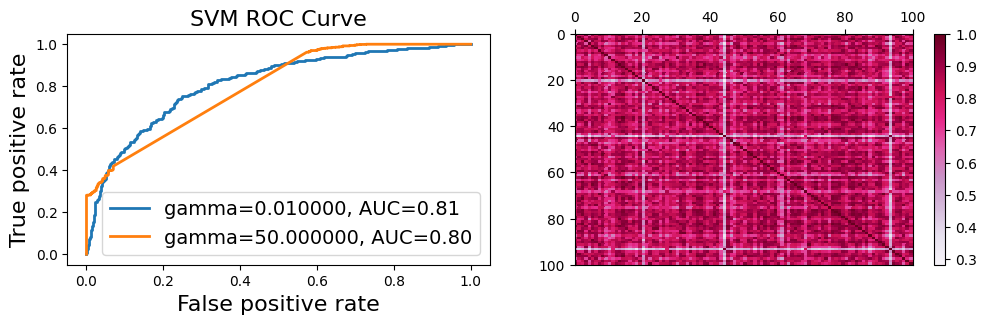

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  

test_gamma([0.01,50], axs)
gram_matrix(0.01, axs)

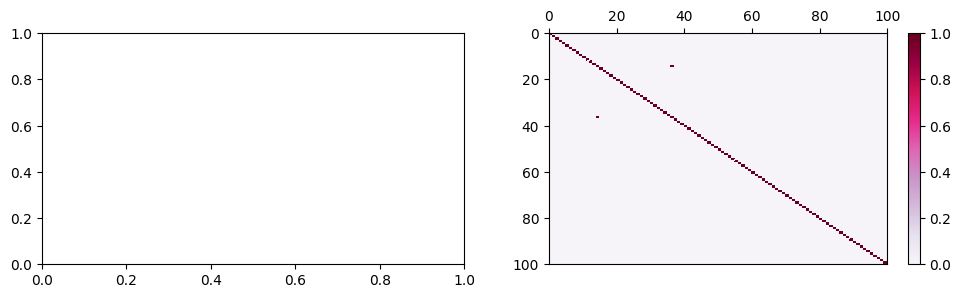

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  

gram_matrix(50, axs)

In [14]:
C_range = np.logspace(-2,3,6)
C_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [15]:
gamma_range = np.logspace(-2,1,4)
gamma_range

array([ 0.01,  0.1 ,  1.  , 10.  ])

In [16]:
param_grid = {'C': C_range, 'gamma': gamma_range} 
score = "roc_auc"

grid = GridSearchCV(svm.SVC(kernel="rbf"), param_grid,cv=5,scoring=score)

In [17]:
grid.fit(X_train_std, y_train)
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}")

The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.8586818353791366


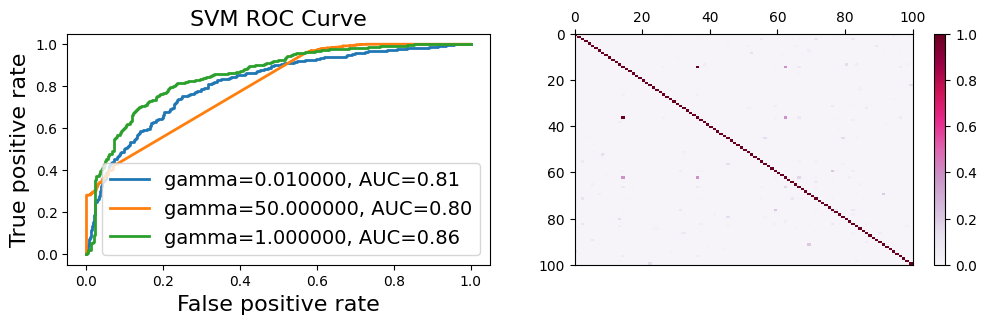

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  
test_gamma([0.01,50, 1], axs)
gram_matrix(1, axs)